# Implementando uma ESN no Sistema de Lorenz

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 125

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

### 1.2 Bibliotecas para Redes Neurais

In [2]:
from pibic2020.models import esn_model

### 1.3 Bibliotecas dos sistemas caóticos

In [3]:
from pibic2020.tools import timeseries
from pibic2020.data import lorenz

## 2. Gerando a série temporal do sistema de Lorenz

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original.

In [4]:
t_inicial = 0
t_final = 50
dt = 0.01

In [5]:
estado_inicial = np.array([0.1, 0, 0])

In [6]:
sis_lorenz = lorenz.SistemaLorenz(estado_inicial, dt=dt)

In [7]:
solucoes, instantes_temporais = sis_lorenz.calcular(t_inicial = t_inicial, t_final = t_final)

In [8]:
x = solucoes[:, 0]
y = solucoes[:, 1]
z = solucoes[:, 2]

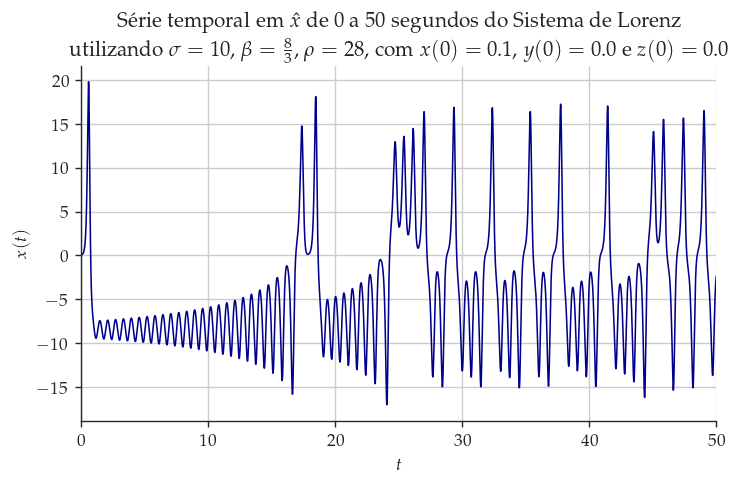

In [9]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_title("Série temporal em $\hat{x}$ de 0 a 50 segundos do Sistema de Lorenz\n utilizando $\sigma = 10$, " + r"$\beta =\frac{8}{3}$, " + r"$\rho=28$, com " + "$x(0) =$ " + str(estado_inicial[0]) + ", $y(0) = $ " + str(estado_inicial[1]) + " e $z(0) =$ " + str(estado_inicial[2]))
ax.plot(instantes_temporais, x, color='DarkBlue', linewidth = 0.9)

ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(0,50)
ax.grid(True)

fig.tight_layout()
sns.despine()
plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [10]:
K = 4
L = 3
tam_teste = 0.15

In [11]:
serie_temporal = timeseries.SerieTemporal(x, K=K, L=L)

In [12]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

## 3. Definindo o modelo ESN, treinando e realizando a predição

In [13]:
n_neurons = 30
leaky_values = np.array([0.9,0.9,0.9,0.9,0.9,0.9])
spectral_radius = np.array([1,1,1,1,1,1])
scale = 1

In [14]:
esn = esn_model.ModeloESN(n_neurons, leaky_values, spectral_radius, scale)

### Treinando

In [15]:
n_transitory_samples = int(0.1*len(X_treino))

In [16]:
esn.treinar(X_treino, y_treino, n_transitory_samples)

In [18]:
y_predicao = esn.predicao(X_teste, n_transitory_samples = int(0.1*len(X_teste)))

ValueError: could not broadcast input array from shape (4245) into shape (751)